In [1]:
from IPython.display import FileLink
from kaggle_datasets import KaggleDatasets

In [2]:
import pandas as pd

train_df = pd.read_csv('/kaggle/input/elreg-datasets/train.csv', delimiter='\t')
test_df = pd.read_csv('/kaggle/input/elreg-datasets/test.csv', delimiter='\t')
dev_df = pd.read_csv('/kaggle/input/elreg-datasets/dev.csv', delimiter='\t')

In [3]:
train_df

,ID,Tweet,joy,sadness,anger,fear
0,2017-En-10000,How the fu*k! Who the heck! moved my fridge!.....,0.0,0.000,0.938,0.0
1,2017-En-10001,So my Indian Uber driver just called someone t...,0.0,0.000,0.896,0.0
2,2017-En-10002,@DPD_UK I asked for my parcel to be delivered ...,0.0,0.000,0.896,0.0
3,2017-En-10003,so ef whichever butt wipe pulled the fire alar...,0.0,0.000,0.896,0.0
4,2017-En-10004,Don't join @BTCare they put the phone down on ...,0.0,0.000,0.896,0.0
...,...,...,...,...,...,...
6903,2017-En-41528,Why does Candice constantly pout #GBBO 💄😒,0.0,0.396,0.375,0.0
6904,2017-En-41529,"@redBus_in #unhappy with #redbus CC, when I ta...",0.0,0.604,0.000,0.0
6905,2017-En-41530,"@AceOperative789 no pull him afew weeks ago, s...",0.0,0.479,0.000,0.0
6906,2017-En-41531,I'm buying art supplies and I'm debating how s...,0.0,0.375,0.000,0.0


In [4]:
print(train_df.isnull().sum(), '\n')
print(test_df.isnull().sum(), '\n')
print(dev_df.isnull().sum(), '\n')

ID         0
Tweet      0
joy        0
sadness    0
anger      0
fear       0
dtype: int64 

ID         0
Tweet      0
joy        0
sadness    0
anger      0
fear       0
dtype: int64 

ID         0
Tweet      0
joy        0
sadness    0
anger      0
fear       0
dtype: int64 



In [5]:
print(train_df.duplicated().sum(), '\n')
print(test_df.duplicated().sum(), '\n')
print(dev_df.duplicated().sum(), '\n')

0 

0 

0 



# Data Preprocessing (Modifying Train Set)

In [6]:
!pip install emoji contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.9 MB/s eta 0:00:00


In [7]:
import re
import emoji
import contractions

def convert_emojis(text):
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r':([a-zA-Z_]+):', r'\1', text)
    text = text.replace('_', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_text(text):
    # Lowercase
    text = text.lower()
    # expand contractions
    text = contractions.fix(text)
    # convert emojis
    text = convert_emojis(text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    # text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and numbers (except punctuation)
    text = re.sub(r"[^a-zA-Z\s.,!?':#-]", '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [8]:
train_df["clean_text"] = train_df["Tweet"].apply(clean_text)
dev_df["clean_text"] = dev_df["Tweet"].apply(clean_text)
test_df["clean_text"] = test_df["Tweet"].apply(clean_text)

In [9]:
train_df['clean_text']

0       how the fuk! who the heck! moved my fridge!......
1       so my indian uber driver just called someone t...
2       uk i asked for my parcel to be delivered to a ...
3       so ef whichever butt wipe pulled the fire alar...
4       do not join they put the phone down on you, ta...
                              ...                        
6903    why does candice constantly pout #gbbo lipstic...
6904    in #unhappy with #redbus cc, when i talked wit...
6905    no pull him afew weeks ago, sadly there is no ...
6906    i am buying art supplies and i am debating how...
6907    could you ask your chafford hundred store to t...
Name: clean_text, Length: 6908, dtype: object

In [10]:
def flatten_df(df):
  emotion_cols = ["joy", "sadness", "anger", "fear"]
  flat_rows = []

  for _, row in df.iterrows():
    emo_int = {
        emotion: row[emotion]
        for emotion in emotion_cols
        if not pd.isna(row[emotion])
    }
    if not emo_int:
      continue

    max_int = max(emo_int.values())

    for emotion, intensity in emo_int.items():
      if (intensity >= max_int - 0.1) and (intensity > 0.0):
        flat_rows.append({
          "ID": row["ID"],
          "Tweet": row["clean_text"],
          "Emotion": emotion,
          "Intensity": intensity
        })

  # for _, row in df.iterrows():
  #   for emotion in emotion_cols:
  #     intensity = row[emotion]
  #     if not pd.isna(intensity) and intensity > 0.0:
  #               flat_rows.append({
  #                   "ID": row["ID"],
  #                   "Tweet": row["clean_text"],
  #                   "Emotion": emotion,
  #                   "Intensity": intensity
  #               })

  return pd.DataFrame(flat_rows)

In [11]:
clean_train_df = flatten_df(train_df)
clean_test_df = flatten_df(test_df)
clean_dev_df = flatten_df(dev_df)

In [12]:
clean_train_df

,ID,Tweet,Emotion,Intensity
0,2017-En-10000,how the fuk! who the heck! moved my fridge!......,anger,0.938
1,2017-En-10001,so my indian uber driver just called someone t...,anger,0.896
2,2017-En-10002,uk i asked for my parcel to be delivered to a ...,anger,0.896
3,2017-En-10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,2017-En-10004,"do not join they put the phone down on you, ta...",anger,0.896
...,...,...,...,...
7005,2017-En-41528,why does candice constantly pout #gbbo lipstic...,anger,0.375
7006,2017-En-41529,"in #unhappy with #redbus cc, when i talked wit...",sadness,0.604
7007,2017-En-41530,"no pull him afew weeks ago, sadly there is no ...",sadness,0.479
7008,2017-En-41531,i am buying art supplies and i am debating how...,sadness,0.375


In [13]:
!pip install nltk nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 12.1 MB/s eta 0:00:00


In [14]:
# Synonym Replacement
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [15]:
import torch
import nlpaug.augmenter.word as naw
import random
syn_aug = naw.SynonymAug(aug_src='wordnet', lang='eng')

2025-05-19 12:00:14.193717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747656014.386907      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747656014.445429      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Synonym Replacement Cell

In [16]:
# Synonym Replacement
import random
from tqdm import tqdm

target_count = 2500
label_count = clean_train_df['Emotion'].value_counts().to_dict()
augmented_rows = []

for label, count in label_count.items():
  if count < target_count:
    req_augment = target_count - count
    print(f"Augmenting {label}: need {req_augment}")

    emotion_df = clean_train_df[clean_train_df['Emotion'] == label]
    samples = emotion_df.sample(req_augment, replace = True, random_state = 42)

    for _, row in tqdm(samples.iterrows(), total = len(samples), desc = f"Augmenting {label}"):
      try:
        aug_text = syn_aug.augment(row['Tweet'])
        if isinstance(aug_text, list):
          aug_text = aug_text[0]
        augmented_rows.append({
            'ID': str(row['ID']) + "_syn",
            'Tweet': aug_text,
            'Emotion': row['Emotion'],
            'Intensity': row['Intensity']
        })
      except Exception as e:
        print(f"Failed to augment: {e}")
        continue

df_augmented = pd.DataFrame(augmented_rows)
clean_train_df = pd.concat([clean_train_df, df_augmented], ignore_index=True)

clean_train_df = clean_train_df.sample(frac = 1, random_state = 42).reset_index(drop=True)
clean_train_df['Emotion'].value_counts()

Augmenting fear: need 278


Augmenting fear: 100%|██████████| 278/278 [00:00<00:00, 532.51it/s]


Augmenting anger: need 823


Augmenting anger: 100%|██████████| 823/823 [00:00<00:00, 869.97it/s]


Augmenting joy: need 892


Augmenting joy: 100%|██████████| 892/892 [00:00<00:00, 989.86it/s] 


Augmenting sadness: need 997


Augmenting sadness: 100%|██████████| 997/997 [00:00<00:00, 1015.68it/s]


Emotion
sadness    2500
joy        2500
fear       2500
anger      2500
Name: count, dtype: int64

## NRC EmoLex

In [17]:
from collections import defaultdict

def load_lex(filepath):
  lexicon = defaultdict(dict)
  with open(filepath, 'r') as file:
    for line in file:
      word, emotion, value = line.strip().split('\t')
      if int(value) == 1:
        lexicon[word][emotion] = 1

  return lexicon

nrc_lexicon = load_lex("/kaggle/input/nrc-lexicons/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")

In [18]:
import numpy as np

def extract_lex(text, lexicon):
  emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
              'sadness', 'surprise', 'trust', 'positive', 'negative']
  counts = dict.fromkeys(emotions, 0)

  for word in text.split():
    if word in lexicon:
      for emo in lexicon[word]:
        counts[emo] += 1
  return [counts[emo] for emo in emotions]

In [19]:
clean_train_df['lexicons'] = clean_train_df['Tweet'].apply(lambda x: extract_lex(x, nrc_lexicon))
clean_test_df['lexicons'] = clean_test_df['Tweet'].apply(lambda x: extract_lex(x, nrc_lexicon))
clean_dev_df['lexicons'] = clean_dev_df['Tweet'].apply(lambda x: extract_lex(x, nrc_lexicon))

train_lex = np.array(clean_train_df['lexicons'].tolist())
test_lex = np.array(clean_test_df['lexicons'].tolist())
dev_lex = np.array(clean_dev_df['lexicons'].tolist())

## NRC VAD

In [20]:
def load_nrc_vad(filepath):
    vad_lex = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        next(f)  # skip header
        for line in f:
            word, val, aro, dom = line.strip().split('\t')
            vad_lex[word] = {
                'valence': float(val),
                'arousal': float(aro),
                'dominance': float(dom)
            }
    return vad_lex

nrc_vad_lexicon = load_nrc_vad("/kaggle/input/nrc-lexicons/NRC-VAD-Lexicon-v2.1.txt")

In [21]:
def extract_vad(text, lexicon):
    valence = []
    arousal = []
    dominance = []

    for word in text.split():
        if word in lexicon:
            valence.append(lexicon[word]['valence'])
            arousal.append(lexicon[word]['arousal'])
            dominance.append(lexicon[word]['dominance'])

    # If no word matched, return zeros
    if not valence:
        return [0.0, 0.0, 0.0]

    # Otherwise, return means
    return [
        np.mean(valence),
        np.mean(arousal),
        np.mean(dominance)
    ]

In [22]:
clean_train_df['vad'] = clean_train_df['Tweet'].apply(lambda x: extract_vad(x, nrc_vad_lexicon))
clean_test_df['vad'] = clean_test_df['Tweet'].apply(lambda x: extract_vad(x, nrc_vad_lexicon))
clean_dev_df['vad'] = clean_dev_df['Tweet'].apply(lambda x: extract_vad(x, nrc_vad_lexicon))

train_vad = np.array(clean_train_df['vad'].tolist())
test_vad = np.array(clean_test_df['vad'].tolist())
dev_vad = np.array(clean_dev_df['vad'].tolist())

## NRC Hash-Emo

In [23]:
from collections import defaultdict

def load_nrc_hash_emo(filepath):
    lexicon = defaultdict(dict)
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            emotion, word, score = line.strip().split('\t')
            lexicon[word][emotion] = float(score)
    return lexicon

hash_emo_lex = load_nrc_hash_emo('/kaggle/input/nrc-lexicons/NRC-Hashtag-Emotion-Lexicon-v0.2.txt')

In [24]:
def extract_hash_emo(text, lexicon):
    emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                'sadness', 'surprise', 'trust']
    scores = {emo: [] for emo in emotions}

    for word in text.split():
        if word in lexicon:
            for emo, value in lexicon[word].items():
                scores[emo].append(value)

    return [np.mean(scores[emo]) if scores[emo] else 0.0 for emo in emotions]

In [25]:
clean_train_df['hash'] = clean_train_df['Tweet'].apply(lambda x: extract_hash_emo(x, hash_emo_lex))
clean_test_df['hash'] = clean_test_df['Tweet'].apply(lambda x: extract_hash_emo(x, hash_emo_lex))
clean_dev_df['hash'] = clean_dev_df['Tweet'].apply(lambda x: extract_hash_emo(x, hash_emo_lex))

train_hash = np.array(clean_train_df['hash'].tolist())
test_hash = np.array(clean_test_df['hash'].tolist())
dev_hash = np.array(clean_dev_df['hash'].tolist())

## Lexicon Standardization

In [26]:
from sklearn.preprocessing import StandardScaler

scaler_hash = StandardScaler()
train_hash = scaler_hash.fit_transform(train_hash)
test_hash = scaler_hash.transform(test_hash)
dev_hash = scaler_hash.transform(dev_hash)

scaler_lex = StandardScaler()
train_lex = scaler_lex.fit_transform(train_lex)
test_lex = scaler_lex.transform(test_lex)
dev_lex = scaler_lex.transform(dev_lex)

## Lexicon Combinations

In [27]:
# # NRC VAD + EmoLex
# train_combined = np.concatenate([train_vad, train_lex], axis=1)
# test_combined = np.concatenate([test_vad, test_lex], axis=1)
# dev_combined = np.concatenate([dev_vad, dev_lex], axis=1)

In [28]:
# #NRC Hash-Emo + EmoLex
# train_combined = np.concatenate([train_hash, train_lex], axis=1)
# test_combined = np.concatenate([test_hash, test_lex], axis=1)
# dev_combined = np.concatenate([dev_hash, dev_lex], axis=1)

In [29]:
# NRC Hash-Emo + EmoLex + VAD
train_combined = np.concatenate([train_vad, train_lex, train_hash], axis=1)
test_combined = np.concatenate([test_vad, test_lex, test_hash], axis=1)
dev_combined = np.concatenate([dev_vad, dev_lex, dev_hash], axis=1)

# Data Preparation (Encoding & Tokenized)

In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
clean_train_df['Emotion'] = le.fit_transform(clean_train_df['Emotion'])
clean_test_df['Emotion'] = le.fit_transform(clean_test_df['Emotion'])
clean_dev_df['Emotion'] = le.fit_transform(clean_dev_df['Emotion'])

## Store mapping just in case
label2emotion = dict(enumerate(le.classes_))
emotion2label = {v: k for k, v in label2emotion.items()}

In [31]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts, max_len = 128):
  return tokenizer(
      texts.tolist(),
      padding = 'max_length',
      truncation = True,
      max_length = max_len,
      return_tensors = 'pt'
  )

train_tokenized = tokenize_texts(clean_train_df['Tweet'])
test_tokenized = tokenize_texts(clean_test_df['Tweet'])
dev_tokenized = tokenize_texts(clean_dev_df['Tweet'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [32]:
import torch
train_cls_label = torch.tensor(clean_train_df['Emotion'].values)
test_cls_label = torch.tensor(clean_test_df['Emotion'].values)
dev_cls_label = torch.tensor(clean_dev_df['Emotion'].values)

In [33]:
train_reg_label = torch.tensor(clean_train_df['Intensity'].values, dtype=torch.float)
test_reg_label = torch.tensor(clean_test_df['Intensity'].values, dtype=torch.float)
dev_reg_label = torch.tensor(clean_dev_df['Intensity'].values, dtype=torch.float)

In [34]:
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels, texts=None, lexicon_feats=None, emotion_labels=None):
        self.encodings = encodings
        self.labels = labels
        self.texts = texts
        self.lexicon_feats = lexicon_feats
        self.emotion_labels = emotion_labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        if self.texts is not None:
          item['text'] = self.texts[idx]
        if self.lexicon_feats is not None:
          item['lexicon_feats'] = torch.tensor(
              self.lexicon_feats[idx],
              dtype = torch.float)
        if self.emotion_labels is not None:
            item['emotions'] = self.emotion_labels[idx]
        return item

In [35]:
## Dataset and DataLoader for train cls and reg
from torch.utils.data import DataLoader
train_dataset_cls = EmotionDataset(
    train_tokenized,
    train_cls_label,
    texts=clean_train_df['Tweet'],
    lexicon_feats=train_combined
)
train_loader_cls = DataLoader(
    train_dataset_cls,
    batch_size=16,
    shuffle=True
)

train_dataset_reg = EmotionDataset(
    train_tokenized,
    train_reg_label,
    texts=clean_train_df['Tweet'],
    lexicon_feats=train_combined,
    emotion_labels=clean_train_df['Emotion'].tolist()
)
train_loader_reg = DataLoader(
    train_dataset_reg,
    batch_size=16,
    shuffle=True
)

In [36]:
## Dataset and DataLoader for test cls and reg
test_dataset_cls = EmotionDataset(
    test_tokenized,
    test_cls_label,
    texts=clean_test_df['Tweet'],
    lexicon_feats=test_combined
)
test_loader_cls = DataLoader(
    test_dataset_cls,
    batch_size=16,
    shuffle=False
)

test_dataset_reg = EmotionDataset(
    test_tokenized,
    test_reg_label,
    texts=clean_test_df['Tweet'],
    lexicon_feats=test_combined,
    emotion_labels=clean_test_df['Emotion'].tolist()
)
test_loader_reg = DataLoader(
    test_dataset_reg,
    batch_size=16,
    shuffle=False
)

In [37]:
## Dataset and DataLoader for dev(val) cls and reg
dev_dataset_cls = EmotionDataset(
    dev_tokenized,
    dev_cls_label,
    texts=clean_dev_df['Tweet'],
    lexicon_feats=dev_combined
)
dev_loader_cls = DataLoader(
    dev_dataset_cls,
    batch_size=16,
    shuffle=True
)

dev_dataset_reg = EmotionDataset(
    dev_tokenized,
    dev_reg_label,
    texts=clean_dev_df['Tweet'],
    lexicon_feats=dev_combined,
    emotion_labels=clean_dev_df['Emotion'].tolist()
)
dev_loader_reg = DataLoader(
    dev_dataset_reg,
    batch_size=16,
    shuffle=True
)

In [38]:
from transformers import BertModel, get_scheduler
from torch.optim import AdamW
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# #2-Layer MLP
# class BertForEmotionClassification(nn.Module):
#     def __init__(self, lex_dim = 10, num_labels=4, hidden_dim=64, dropout_prob=0.3):
#         super(BertForEmotionClassification, self).__init__()
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.dropout = nn.Dropout(dropout_prob)

#         input_dim = self.bert.config.hidden_size + lex_dim

#         self.classifier = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(hidden_dim, num_labels)
#         )

#     def forward(self, input_ids, attention_mask, lexicon_feats):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = outputs.pooler_output
#         combined = torch.cat((pooled_output, lexicon_feats), dim=1)
#         x = self.dropout(combined)
#         return self.classifier(x)

In [41]:
class BertForEmotionClassification(nn.Module):
    def __init__(self, lex_dim = 10, num_labels=4):
        super(BertForEmotionClassification, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size + lex_dim, num_labels)

    def forward(self, input_ids, attention_mask, lexicon_feats):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        combined = torch.cat((pooled_output, lexicon_feats), dim=1)
        x = self.dropout(combined)
        return self.fc(x)

In [42]:
num_label = len(le.classes_)
# lex_dim = train_lex.shape[1]
# vad_dim = train_vad.shape[1]
# hash_dim = train_hash.shape[1]

com_dim = train_combined.shape[1]

model = BertForEmotionClassification(
    lex_dim=com_dim,
    num_labels=num_label
)

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForEmotionClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [43]:
optimizer = AdamW(model.parameters(), lr=2e-5,  weight_decay=0.01)
criteration = nn.CrossEntropyLoss(label_smoothing=0.1)

patience = 2
early_stop_count = 0
best_val_loss = float('inf')

num_epochs = 10
num_training_steps = num_epochs * len(train_loader_cls)
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [44]:
for epoch in range(num_epochs):
    model.train()
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_losses = []
    loop = tqdm(train_loader_cls, leave=True)

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        lexicon_feats = batch['lexicon_feats'].to(device).float()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, lexicon_feats=lexicon_feats)

        loss = criteration(outputs, labels)
        logits = outputs

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        train_losses.append(loss.item())

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
      for batch in dev_loader_cls:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        lexicon_feats = batch['lexicon_feats'].to(device).float()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, lexicon_feats=lexicon_feats)

        loss = criteration(outputs, labels)
        val_losses.append(loss.item())

      avg_val_loss = sum(val_losses) / len(val_losses)
      avg_train_loss = sum(train_losses) / len(train_losses)
      print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

      # Early stopping check
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_count = 0
        # Save the best model
        torch.save(model.state_dict(), "best_classification_model_2.pth")
      else:
        early_stop_count += 1
        print(f"Validation loss did not improve. Early stop counter: {early_stop_count}/{patience}")

      if early_stop_count >= patience:
        print("Early stopping triggered.")
        break


Epoch 1/10


Epoch 1: 100%|██████████| 625/625 [02:07<00:00,  4.91it/s, loss=0.652]


Train Loss: 1.1375 | Validation Loss: 1.2441

Epoch 2/10


Epoch 2: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, loss=0.48] 


Train Loss: 0.5748 | Validation Loss: 1.2811
Validation loss did not improve. Early stop counter: 1/2

Epoch 3/10


Epoch 3: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, loss=0.422]


Train Loss: 0.4689 | Validation Loss: 1.3060
Validation loss did not improve. Early stop counter: 2/2
Early stopping triggered.


In [45]:
# tokenizer.save_pretrained("bert_tokenizer_2")

In [46]:
model = BertForEmotionClassification(
    lex_dim=com_dim,
    num_labels=num_label
).to(device)
model.load_state_dict(torch.load("/kaggle/working/best_classification_model_2.pth"))

<All keys matched successfully>

In [47]:
# !zip -r bert-emotion-classifier.zip bert-emotion-classifier
# files.download("bert-emotion-classifier.zip")

In [48]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def model_eval(model, dataloader, device):
  model.eval()
  preds = []
  true_labels = []
  texts = []

  with torch.no_grad():
    for batch in dataloader:
      texts.extend(batch['text'])
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      lexicon_feats = batch['lexicon_feats'].to(device).float()

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, lexicon_feats=lexicon_feats)
      logits = outputs

      predictions = torch.argmax(logits, dim=1)
      preds.extend(predictions.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

  acc = accuracy_score(true_labels, preds)
  report = classification_report(true_labels, preds, target_names=[str(c) for c in le.classes_])

  return acc, report, true_labels, preds, texts

In [49]:
accuracy, report, y_true, y_pred, ori_texts = model_eval(model, test_loader_cls, device)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Accuracy: 0.7315
Classification Report:
              precision    recall  f1-score   support

       anger       0.77      0.71      0.74       859
        fear       0.63      0.73      0.67       852
         joy       0.85      0.82      0.83      1092
     sadness       0.67      0.64      0.65       817

    accuracy                           0.73      3620
   macro avg       0.73      0.72      0.72      3620
weighted avg       0.74      0.73      0.73      3620



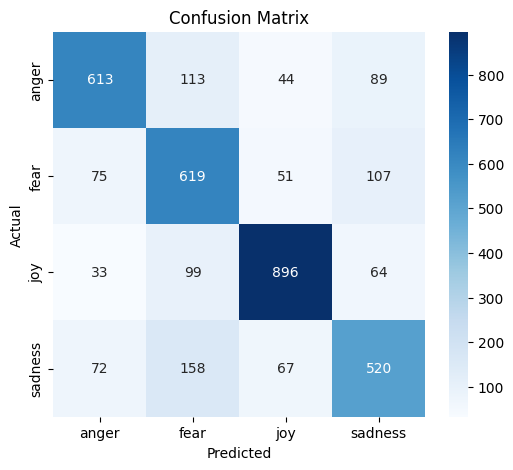

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Regression Model

In [52]:
# class BertForEmotionIntensity(nn.Module):
#     def __init__(self, lex_dim=10):
#         super(BertForEmotionIntensity, self).__init__()
#         self.bert = BertModel.from_pretrained("bert-base-uncased")
#         self.dropout = nn.Dropout(0.3)
#         self.regressor = nn.Linear(self.bert.config.hidden_size + lex_dim, 1)

#     def forward(self, input_ids, attention_mask, lexicon_feats):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = outputs.pooler_output
#         combined = torch.cat((pooled_output, lexicon_feats), dim=1)
#         x = self.dropout(combined)
#         return torch.sigmoid(self.regressor(x).squeeze(-1))

In [53]:
class BertForEmotionIntensity(nn.Module):
    def __init__(self, lex_dim=10):
        super(BertForEmotionIntensity, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.regressor = nn.Linear(self.bert.config.hidden_size + lex_dim, 1)

    def forward(self, input_ids, attention_mask, lexicon_feats):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        combined = torch.cat((pooled_output, lexicon_feats), dim=1)
        x = self.dropout(combined)
        raw_out = self.regressor(x).squeeze(-1)
        return (torch.tanh(raw_out) + 1) / 2

In [54]:
def pearson_loss(preds, targets):
    vx = preds - preds.mean()
    vy = targets - targets.mean()
    corr = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)) + 1e-8)
    return 1 - corr

In [55]:
smooth_l1 = nn.HuberLoss(delta=0.3)
def criteration(preds, targets, alpha=0.8):
    loss1 = smooth_l1(preds, targets)
    loss2 = pearson_loss(preds, targets)
    return alpha * loss1 + (1 - alpha) * loss2

In [56]:
model_reg = BertForEmotionIntensity(
    lex_dim=com_dim
).to(device)

optimizer = AdamW(model_reg.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 10
num_training_steps = num_epochs * len(train_loader_reg)
num_warmup_steps = int(0.1 * num_training_steps)

patience = 3
best_val_loss = float('inf')
early_stop_count = 0

lr_scheduler = get_scheduler(
    name="cosine_with_restarts",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [57]:
for epoch in range(num_epochs):
    model_reg.train()
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_losses = []
    loop = tqdm(train_loader_reg, leave=True)

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()
        lexicon_feats = batch['lexicon_feats'].to(device).float()

        outputs = model_reg(input_ids=input_ids, attention_mask=attention_mask, lexicon_feats=lexicon_feats)

        optimizer.zero_grad()
        loss = criteration(outputs, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        train_losses.append(loss.item())

        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    model_reg.eval()
    val_losses = []
    with torch.no_grad():
        for batch in dev_loader_reg:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()
            lexicon_feats = batch['lexicon_feats'].to(device).float()

            outputs = model_reg(input_ids=input_ids, attention_mask=attention_mask, lexicon_feats=lexicon_feats)

            val_loss = criteration(outputs, labels)
            val_losses.append(val_loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_train_loss = sum(train_losses) / len(train_losses)
    print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_count = 0
        # Save best model
        torch.save(model_reg.state_dict(), "best_regression_model_3.pth")
    else:
        early_stop_count += 1
        print(f"Validation loss did not improve. Early stop counter: {early_stop_count}/{patience}")

    if early_stop_count >= patience:
        print("Early stopping triggered.")
        break


Epoch 1/10


Epoch 1: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, loss=0.14]  


Train Loss: 0.1717 | Validation Loss: 0.1245

Epoch 2/10


Epoch 2: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, loss=0.0882]


Train Loss: 0.0879 | Validation Loss: 0.1012

Epoch 3/10


Epoch 3: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, loss=0.0613] 


Train Loss: 0.0529 | Validation Loss: 0.0987

Epoch 4/10


Epoch 4: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, loss=0.0795] 


Train Loss: 0.0342 | Validation Loss: 0.0932

Epoch 5/10


Epoch 5: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, loss=0.0258] 


Train Loss: 0.0246 | Validation Loss: 0.0964
Validation loss did not improve. Early stop counter: 1/3

Epoch 6/10


Epoch 6: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, loss=0.0307] 


Train Loss: 0.0194 | Validation Loss: 0.1004
Validation loss did not improve. Early stop counter: 2/3

Epoch 7/10


Epoch 7: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, loss=0.0086] 


Train Loss: 0.0156 | Validation Loss: 0.0969
Validation loss did not improve. Early stop counter: 3/3
Early stopping triggered.


In [58]:
# files.download("best_regression_model_3.pth")

In [59]:
model_reg = BertForEmotionIntensity(lex_dim = com_dim).to(device)
model_reg.load_state_dict(torch.load("/kaggle/working/best_regression_model_3.pth"))

<All keys matched successfully>

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import numpy as np
from collections import defaultdict

def modelRegEval(model, dataloader, device):
    model.eval()
    preds = []
    true_vals = []
    emotions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()
            lexicon_feats = batch['lexicon_feats'].to(device).float()
            emotion_labels = batch['emotions']

            outputs = model_reg(input_ids=input_ids, attention_mask=attention_mask, lexicon_feats=lexicon_feats)

            preds.extend(outputs.squeeze().cpu().numpy())
            true_vals.extend(labels.squeeze().cpu().numpy())
            emotions.extend([label2emotion[e.item()] for e in emotion_labels])

    mse = mean_squared_error(true_vals, preds)
    mae = mean_absolute_error(true_vals, preds)
    r2 = r2_score(true_vals, preds)
    pearson, _ = pearsonr(true_vals, preds)

    emotion_dict = defaultdict(lambda: {"true": [], "pred": []})
    for e, t, p in zip(emotions, true_vals, preds):
        emotion_dict[e]["true"].append(t)
        emotion_dict[e]["pred"].append(p)

    per_emotion_pearson = {}
    for e in sorted(emotion_dict.keys()):
        true_e = emotion_dict[e]["true"]
        pred_e = emotion_dict[e]["pred"]
        if len(true_e) > 1:
            p_corr, _ = pearsonr(true_e, pred_e)
            per_emotion_pearson[e] = p_corr
        else:
            per_emotion_pearson[e] = None

    avg_pearson = np.mean([v for v in per_emotion_pearson.values() if v is not None])
    
    return {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'pearson_global': pearson,
        'per_emotion_pearson': per_emotion_pearson,
        'avg_pearson': avg_pearson,
        'true_vals': true_vals,
        'preds': preds,
        'emotions': emotions
    }

In [61]:
train_rets = modelRegEval(model_reg, train_loader_reg, device)
print("Global Score:")
print(f"Mean Squared Error (MSE): {train_rets['mse']:.4f}")
print(f"Mean Absolute Error (MAE): {train_rets['mae']:.4f}")
print(f"R2 Score: {train_rets['r2']:.4f}")
print(f"Pearson Score: {train_rets['pearson_global']:.4f}\n")

print("Per Emotion Score:")
for emo, score in train_rets["per_emotion_pearson"].items():
    if score is not None:
        print(f"{emo}: {score:.4f}")
    else:
        print(f"{emo}: Not enough pearson data.")
print(f"Average Pearson:", train_rets['avg_pearson'])

Global Score:
Mean Squared Error (MSE): 0.0084
Mean Absolute Error (MAE): 0.0729
R2 Score: 0.7766
Pearson Score: 0.9329

Per Emotion Score:
anger: 0.9235
fear: 0.9397
joy: 0.9254
sadness: 0.9460
Average Pearson: 0.93367463


In [62]:
test_rets = modelRegEval(model_reg, test_loader_reg, device)
print("Global Score:")
print(f"Mean Squared Error (MSE): {test_rets['mse']:.4f}")
print(f"Mean Absolute Error (MAE): {test_rets['mae']:.4f}")
print(f"R2 Score: {test_rets['r2']:.4f}")
print(f"Pearson Score: {test_rets['pearson_global']:.4f}\n")

print("Per Emotion Score:")
for emo, score in test_rets["per_emotion_pearson"].items():
    print(f"{emo}: {score:.4f}")
print(f"Average Pearson:", test_rets['avg_pearson'])

Global Score:
Mean Squared Error (MSE): 0.0282
Mean Absolute Error (MAE): 0.1309
R2 Score: 0.1891
Pearson Score: 0.6130

Per Emotion Score:
anger: 0.6681
fear: 0.6623
joy: 0.4999
sadness: 0.6747
Average Pearson: 0.6262355


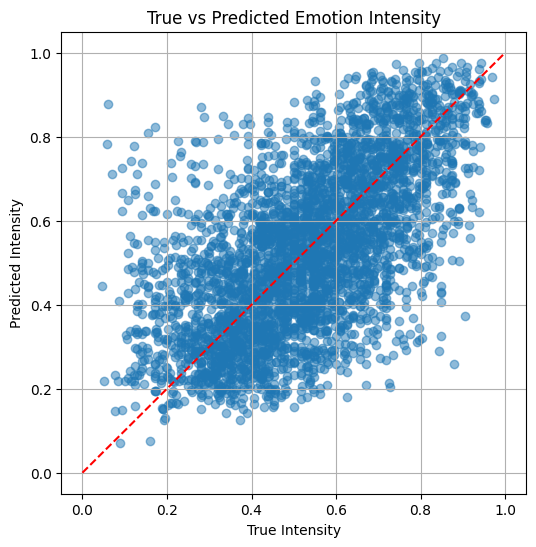

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(test_rets['true_vals'], test_rets['preds'], alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # y = x line
plt.xlabel("True Intensity")
plt.ylabel("Predicted Intensity")
plt.title("True vs Predicted Emotion Intensity")
plt.grid(True)
plt.show()